In [1]:
import numpy as np
import numpy.random as rn
import matplotlib.pyplot as plt
%matplotlib inline


In [43]:
## Define the gridworld MDP class

class Gridworld(object):
    """
    Gridworld MDP.
    """
    
    def __init__(self, grid_size, wind, discount, reward_func):
        """
        grid_size: Grid size. int.
        wind: Chance of moving randomly. float.
        discount: MDP discount. float.
        -> Gridworld
        """

        self.actions = ((1, 0), (0, 1), (-1, 0), (0, -1))
        self.n_actions = len(self.actions)
        self.n_states = grid_size**2
        self.grid_size = grid_size
        self.wind = wind
        self.discount = discount
        self.reward_func = reward_func

        # Preconstruct the transition probability array.
        self.transition_probability = self.get_transition_probability()

    def __str__(self):
        return "Gridworld({}, {}, {})".format(self.grid_size, self.wind,
                                              self.discount)
    
    def int_to_point(self, i):
        """
        Convert a state int into the corresponding coordinate.

        i: State int.
        -> (x, y) int tuple.
        """

        return (i % self.grid_size, i // self.grid_size)

    def point_to_int(self, p):
        """
        Convert a coordinate into the corresponding state int.

        p: (x, y) tuple.
        -> State int.
        """

        return int(p[0] + p[1]*self.grid_size)

    def neighbouring(self, i, k):
        """
        Get whether two points neighbour each other. Also returns true if they
        are the same point.

        i: (x, y) int tuple.
        k: (x, y) int tuple.
        -> bool.
        """

        return abs(i[0] - k[0]) + abs(i[1] - k[1]) <= 1

    def get_transition_probability(self):
        w = self.wind
        probs = np.zeros(shape=(4,100,100)) # dir, curr, next
        for dir in range(4): # up, down, left, right
          for i in range(100):
            stay = 0
            
            val = w/4 if dir != 0 else 1 - w + (w/4)
            if i%10 == 0: # top edge
              stay += val
            else:
              probs[dir][i][i-1] = val

            val = w/4 if dir != 1 else 1 - w + (w/4)
            if i%10 == 9: # bottom edge
              stay += val
            else:
              probs[dir][i][i+1] = val

            val = w/4 if dir != 2 else 1 - w + (w/4)
            if i < 10: # left edge
              stay += val
            else: 
              probs[dir][i][i-10] = val

            val = w/4 if dir != 3 else 1 - w + (w/4)
            if i >= 90: # right edge
              stay += val
            else:
              probs[dir][i][i+10] = val

            probs[dir][i][i] = stay
        return probs

    def reward(self, state_int):
        """
        Reward for being in state state_int.

        state_int: State integer. int.
        -> Reward.
        """
    
        postive_reward = 10
        negative_reward = -100
        
        #look at figure 6,7 to retrurn a reward at the given state. 
        if self.reward_func == 1:
          if state_int in [14, 15, 24, 25, 28, 29, 38, 39, 52, 53, 62, 63]:
            return -10
          elif state_int == 99:
            return 1.0
          else:
            return 0.0
        else: # reward_func == 2
          if state_int in [41, 42, 43, 44, 45, 46, 51, 61, 62, 63, 67, 68, 73, 77, 83, 84, 85, 86, 87]:
            return -100.0
          elif state_int == 99:
            return 10.0
          else:
            return 0.0
        return None

In [4]:
## Function for plotting the matrix values

def plot_matrix(matrix):
    fig, ax = plt.subplots()
    num_rows = len(matrix)
    min_val, max_val = 0, num_rows

    for i in range(num_rows):
        for j in range(num_rows):
            c = matrix[i][j]
            ax.text(j + 0.5, i + 0.5, '{:.1f}'.format(c), va='center', ha='center')

    ax.set_xlim(min_val, max_val)
    ax.set_ylim(max_val, min_val)
    ax.set_xticks(np.arange(max_val))
    ax.set_yticks(np.arange(max_val))
    ax.xaxis.tick_top()
    ax.grid()
    plt.show()
    plt.close()

In [5]:
## Creating the gridworld MDP with the following parameters

grid_size = 10
wind = 0.1
discount = 0.8

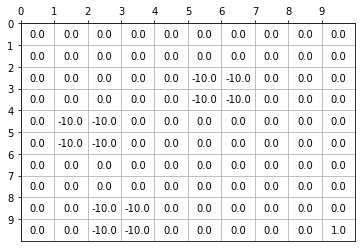

In [6]:
## Plotting the reward value for each state of the grid

def reward_grid_plot(gw):
    reward_matrix = np.zeros((grid_size, grid_size))
    for j in range(grid_size):
        for i in range(grid_size):
            reward_matrix[i][j] = gw.reward(gw.point_to_int((i,j)))
    plot_matrix(reward_matrix)
    return reward_matrix
reward_matrix = reward_grid_plot(Gridworld(grid_size, wind, discount, 1))

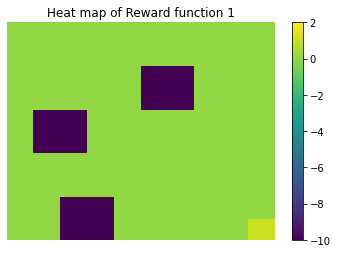

In [7]:
# Question 1
## For visualization generating the heat map of the ground truth reward
plt.pcolor(np.flipud(reward_matrix), vmax=2)
plt.colorbar()
plt.axis('off')
plt.title('Heat map of Reward function 1')
plt.show()

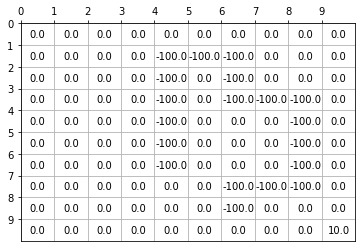

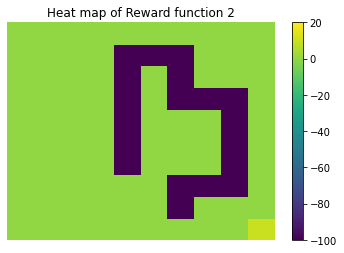

In [8]:
## Plotting the reward value for each state of the grid
reward_matrix = reward_grid_plot(Gridworld(grid_size, wind, discount, 2))
plt.pcolor(np.flipud(reward_matrix), vmax=20)
plt.colorbar()
plt.axis('off')
plt.title('Heat map of Reward function 2')
plt.show()

In [58]:
## Implementing the algorithm for computing the optimal value function for each state
## The algorithm takes as input the MDP and returns an array of optimal values,
## where i^th value in the array corresponds to the optimal value of the i^th state.

def optimal_value(n_states, n_actions, transition_probabilities, reward,
                  discount, threshold=1e-2):
    """
    Find the optimal value function.

    n_states: Number of states. int.
    n_actions: Number of actions. int.
    transition_probabilities: Function taking (action, state, state) to
        transition probabilities.
    reward: Vector of rewards for each state.
    discount: MDP discount factor. float.
    threshold: Convergence threshold, default 1e-2. float.
    -> Array of values for each state
    """

    v = np.zeros(n_states)
    delta = np.inf
    N = 0

    #write code here
    while delta > threshold:
        delta = 0
        prev = np.copy(v)
        for s in range(0, 100):
            up = np.sum(transition_probabilities[0][s] * (reward + (discount*prev)))
            down = np.sum(transition_probabilities[1][s] * (reward + (discount*prev)))
            left = np.sum(transition_probabilities[2][s] * (reward + (discount*prev)))
            right = np.sum(transition_probabilities[3][s] * (reward + (discount*prev)))
            v[s] = max(up, down, left, right)
            delta = max(delta, abs(prev[s] - v[s]))
        N = N + 1
    return v, N

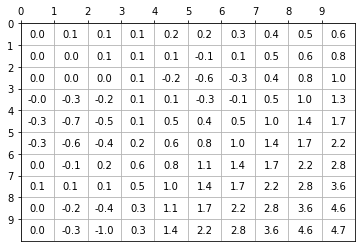

In [59]:
# Question 2

## Plotting the optimal values of each state in the grid

# Generating the array of rewards to be passed onto the optimal value algorithm
gw = Gridworld(grid_size, wind, discount, 1)
reward_states = np.zeros(gw.n_states)
for i in range(gw.n_states):
    reward_states[i] = gw.reward(i)
    
# Computing the optimal value of each state

v, N = optimal_value(gw.n_states, gw.n_actions, gw.transition_probability, reward_states, gw.discount)

# Plotting
value_matrix = np.zeros((grid_size, grid_size))
for i in range(gw.n_states):
    value_matrix[int(i%grid_size)][int(i/grid_size)] = v[i]

plot_matrix(value_matrix)

In [55]:
N

22

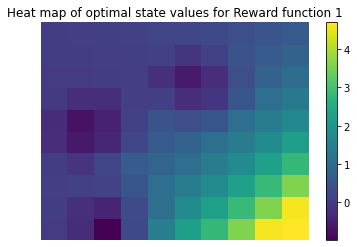

In [56]:
## For visualization generating the heat map of the optimal state values

plt.pcolor(np.flipud(value_matrix))
plt.colorbar()
plt.axis('off')
plt.title('Heat map of optimal state values for Reward function 1')
plt.show()

In [68]:
## Implementing the function for computing the optimal policy.
## The function takes as input the MDP and outputs a
## deterministic policy, which is an array of actions.
## The i^th entry in the array corresponds to the
## optimal action to take at the i^th state.

def find_policy(n_states, n_actions, transition_probabilities, reward, discount,
                threshold=1e-2, v=None, stochastic=False):
    """
    Find the optimal policy.

    n_states: Number of states. int.
    n_actions: Number of actions. int.
    transition_probabilities: Function taking (action, state, state) to
        transition probabilities.
    reward: Vector of rewards for each state.
    discount: MDP discount factor. float.
    threshold: Convergence threshold, default 1e-2. float.
    v: Value function (if known). Default None.
    stochastic: Whether the policy should be stochastic. Default True.
    -> Action probabilities for each state or action int for each state
        (depending on stochasticity).
    """

    if v is None:
        v, _ = optimal_value(n_states, n_actions, transition_probabilities, reward,
                          discount, threshold)

    def _policy(s):
        up = np.sum(transition_probabilities[0][s] * (reward + (discount*v)))
        down = np.sum(transition_probabilities[1][s] * (reward + (discount*v)))
        left = np.sum(transition_probabilities[2][s] * (reward + (discount*v)))
        right = np.sum(transition_probabilities[3][s] * (reward + (discount*v)))
        dirs = [down, right, up, left]
        return dirs.index(max(dirs))
     
    policy = np.array([_policy(s) for s in range(n_states)])
    return policy

In [69]:
## Function for plotting the optimal actions at each state in the grid
## The function takes as input the matrix containing optimal actions
## and plots the actions for each state on the grid

def plot_arrow(action_matrix):
    
    fig, ax = plt.subplots()
    num_rows = len(action_matrix)
    min_val, max_val = 0, num_rows

    for i in range(num_rows):
        for j in range(num_rows):
            c = action_matrix[i][j]
            arrow = ''
            if(c == 0):
                arrow = u'↓'
            elif(c == 1):
                arrow = u'→'
            elif(c == 2):
                arrow = u'↑'
            else:
                arrow = u'←'
            
            ax.text(j + 0.5, i + 0.5, arrow, va='center', ha='center')

    ax.set_xlim(min_val, max_val)
    ax.set_ylim(max_val, min_val)
    ax.set_xticks(np.arange(max_val))
    ax.set_yticks(np.arange(max_val))
    ax.xaxis.tick_top()
    ax.grid()

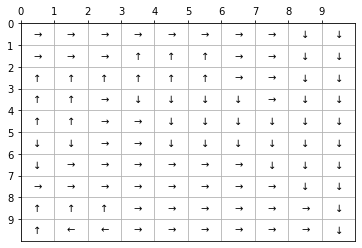

In [70]:
# Question 5

## Plotting the optimal actions for each state in the grid

# Finding the array of optimal policy

optimal_policy = find_policy(gw.n_states, gw.n_actions, gw.transition_probability, reward_states, gw.discount, stochastic=False)

# Generating the matrix containing the optimal actions

action_matrix = np.zeros((grid_size, grid_size))
for i in range(gw.n_states):
    action_matrix[int(i%grid_size)][int(i/grid_size)] = optimal_policy[i]
    

# Plotting
plot_arrow(action_matrix)


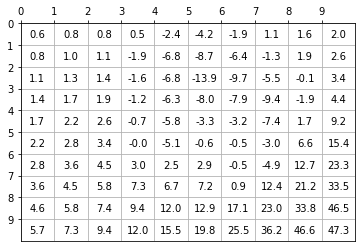

N:  32


In [71]:
#Question 6
gw2 = Gridworld(grid_size, wind, discount, 2)
reward_states = np.zeros(gw2.n_states)
for i in range(gw2.n_states):
    reward_states[i] = gw2.reward(i)
    
# Computing the optimal value of each state

v, N = optimal_value(gw2.n_states, gw2.n_actions, gw2.transition_probability, reward_states, gw2.discount)

# Plotting
value_matrix = np.zeros((grid_size, grid_size))
for i in range(gw2.n_states):
    value_matrix[int(i%grid_size)][int(i/grid_size)] = v[i]

plot_matrix(value_matrix)
print("N: ", N)


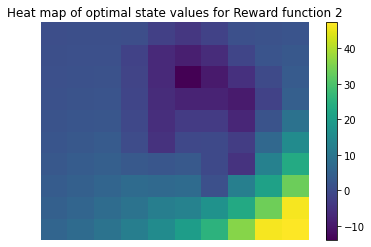

In [72]:
# Question 7
## For visualization generating the heat map of the optimal state values

plt.pcolor(np.flipud(value_matrix))
plt.colorbar()
plt.axis('off')
plt.title('Heat map of optimal state values for Reward function 2')
plt.show()

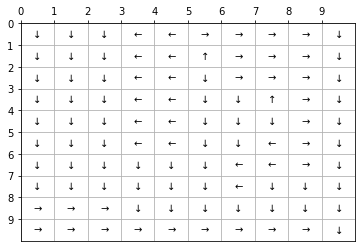

In [73]:
# Question 8
optimal_policy = find_policy(gw2.n_states, gw2.n_actions, gw2.transition_probability, reward_states, gw2.discount, stochastic=False)

# Generating the matrix containing the optimal actions

action_matrix = np.zeros((grid_size, grid_size))
for i in range(gw2.n_states):
    action_matrix[int(i%grid_size)][int(i/grid_size)] = optimal_policy[i]
    

# Plotting
plot_arrow(action_matrix)

N:  19


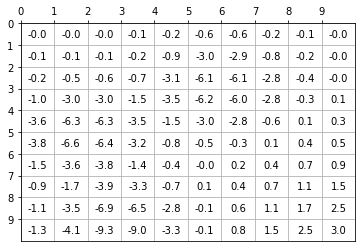

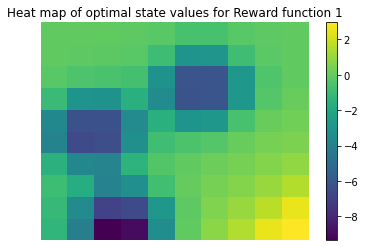

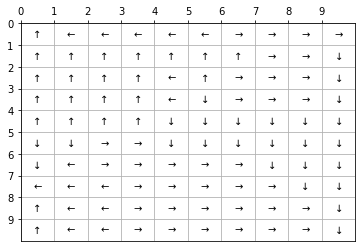

In [75]:
# Question 9
wind = 0.6
gw = Gridworld(grid_size, wind, discount, 1)
reward_states = np.zeros(gw.n_states)
for i in range(gw.n_states):
    reward_states[i] = gw.reward(i)
    
# Computing the optimal value of each state

v, N = optimal_value(gw.n_states, gw.n_actions, gw.transition_probability, reward_states, gw.discount)
print("N: ", N)
# Plotting
value_matrix = np.zeros((grid_size, grid_size))
for i in range(gw.n_states):
    value_matrix[int(i%grid_size)][int(i/grid_size)] = v[i]

plot_matrix(value_matrix)

plt.pcolor(np.flipud(value_matrix))
plt.colorbar()
plt.axis('off')
plt.title('Heat map of optimal state values for Reward function 1')
plt.show()

optimal_policy = find_policy(gw.n_states, gw.n_actions, gw.transition_probability, reward_states, gw.discount, stochastic=False)

# Generating the matrix containing the optimal actions

action_matrix = np.zeros((grid_size, grid_size))
for i in range(gw.n_states):
    action_matrix[int(i%grid_size)][int(i/grid_size)] = optimal_policy[i]
    

# Plotting
plot_arrow(action_matrix)

N:  27


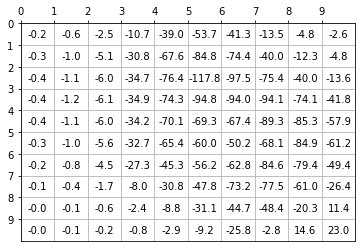

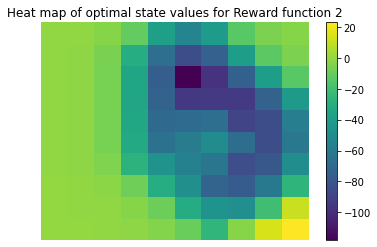

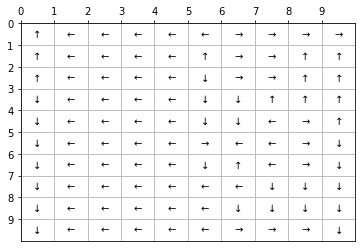

In [77]:
gw2 = Gridworld(grid_size, wind, discount, 2)
reward_states = np.zeros(gw2.n_states)
for i in range(gw2.n_states):
    reward_states[i] = gw2.reward(i)
    
# Computing the optimal value of each state

v, N = optimal_value(gw2.n_states, gw2.n_actions, gw2.transition_probability, reward_states, gw2.discount)
print("N: ", N)
# Plotting
value_matrix = np.zeros((grid_size, grid_size))
for i in range(gw2.n_states):
    value_matrix[int(i%grid_size)][int(i/grid_size)] = v[i]

plot_matrix(value_matrix)

plt.pcolor(np.flipud(value_matrix))
plt.colorbar()
plt.axis('off')
plt.title('Heat map of optimal state values for Reward function 2')
plt.show()

optimal_policy = find_policy(gw2.n_states, gw2.n_actions, gw2.transition_probability, reward_states, gw2.discount, stochastic=False)

# Generating the matrix containing the optimal actions

action_matrix = np.zeros((grid_size, grid_size))
for i in range(gw2.n_states):
    action_matrix[int(i%grid_size)][int(i/grid_size)] = optimal_policy[i]
    

# Plotting
plot_arrow(action_matrix)